## Frequentist A/B Testing ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z
  
  
def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

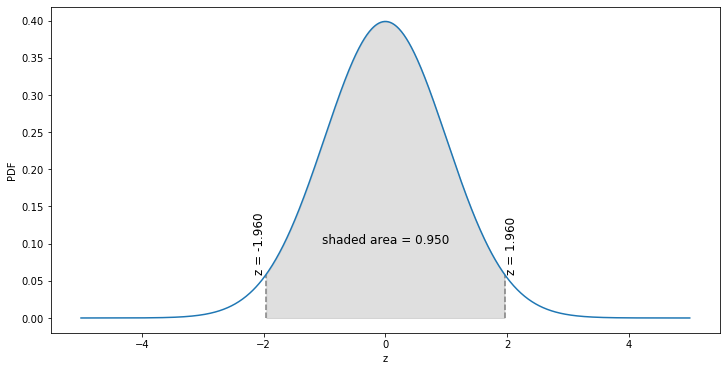

In [3]:
zplot()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import scipy.stats as scs

from scs import pooled_SE, confidence_interval, ab_dist, p_val, z_val

plt.style.use('ggplot')


def plot_norm_dist(ax, mu, sig, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * sig, mu + 12 * sig, 1000)
    y = scs.norm(mu, sig).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, sig, sig_level=sig_level)


def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)


def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    # z = scs.norm().ppf(1 - sig_level/2)
    # left = mu - z * s
    # right = mu + z * s
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")
    # plot_CI(ax, mu=d_hat, s=stderr, sig_level=0.05)


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-3 * d_hat, 3 * d_hat)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_val = p_value(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_val),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()


def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)


def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

ModuleNotFoundError: No module named 'scs'

In [6]:

base_cr = 0.10
d_hat = 0.02 # A relative increase of 20%

N_A = 1000
N_B = 1000

In [11]:
import scipy.stats as scs
import pandas as pd
import numpy as np


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    # initiate bernoulli distributions to randomly sample from
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [26]:
df = generate_data(N_A,N_B,base_cr,base_cr+d_hat)
ab_summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = df.pivot_table(values='converted', index='group')

In [127]:
ab_summary

NameError: name 'ab_summary' is not defined

ab_summary['converted']['A']

# Bayesian A/B Testing #

4 Common Ways to tackle the Bayesian problem:
* Simulation of Posterior Draws
* Numerical Integration
* Closed-form Solution
* Closed-form Approximation

2 Common Decision Rules:
* ROPE Method
* Expected Loss Method

ROPE Method: I want to see a difference of at least j% in my conversion rates before I am willing to choose variant A or B. 

Expected Loss Method: I am willing to choose variant A or B if the loss I am undertaking for this risk is not higher than k. The expected loss must be calculated for both A and B. 

## Simulation of Posterior Draws ##

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=8500, 1410 
imps_test,convs_test=8500, 1500

$posterior = f_{\alpha+K,\beta+N-K}$
where $\alpha,\beta$ are the parameters for the prior
and N is the number of trials, k is the number of successs

In [2]:
# Calculating the parameters for posterior (prior is assumed to be 1,1 - the uninformed guess)
a_C, b_C = 1 + convs_ctrl, 1 + imps_ctrl - convs_ctrl
a_T, b_T = 1 + convs_test, 1 + imps_test - convs_test

In [3]:
# Draw 10000 samples from the distribution
ctrl_simulation = np.random.beta(a_C,b_C,10000)
test_simulation = np.random.beta(a_T,b_T,10000)

In [4]:
# Probability that test simulation outperforms the control simulation (aka Probability to be Best)
np.mean(test_simulation > ctrl_simulation)

0.965

Expected Loss formula from: https://github.com/cbellei/abyes

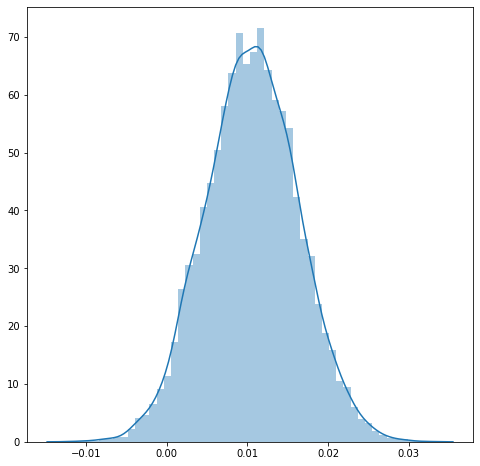

In [14]:
pts = test_simulation - ctrl_simulation
plt.figure(figsize=(8, 8))
sns.distplot(pts)

In [15]:
# bins = np.linspace(np.min(pts) - 0.2 * abs(np.min(pts)), np.max(pts) + 0.2 * abs(np.max(pts)), 1000)
posterior = np.histogram(pts, bins=1000, density=True)
bins = posterior[1]
dl = 0.5 * (bins[0:-1] + bins[1:]) # Calculate bin centers
fdl = posterior[0]
k = np.linspace(0, max(fdl), 1000)
area_above = np.array([np.trapz(fdl[fdl >= kk], dl[fdl >= kk]) for kk in k])
index = np.argwhere(np.abs(area_above - 0.95) == np.min(np.abs(area_above - 0.95)))[0] #0.95 is significance level

In [5]:
inta = np.maximum(dl, 0) * fdl
intb = np.maximum(-dl, 0) * fdl

ela = np.trapz(inta, dl)
elb = np.trapz(intb, dl)
print(ela/0.16588235294117648 * 100)
print(elb/0.16588235294117648 * 100)

NameError: name 'dl' is not defined

Expected Loss formula: https://github.com/FrankPortman/bayesAB

In [18]:
# Expected Loss for choosing variant A
test = (-(test_simulation - ctrl_simulation)/ctrl_simulation)[test_simulation < ctrl_simulation]
print(np.mean(test) * np.mean(test_simulation < ctrl_simulation) * 100)
    
# Expected Loss for choosing variant B
test = ((test_simulation - ctrl_simulation)/ctrl_simulation)[test_simulation > ctrl_simulation] 
print(np.mean(test) * np.mean(test_simulation > ctrl_simulation) * 100)

0.0405885263724118
6.469434158341396


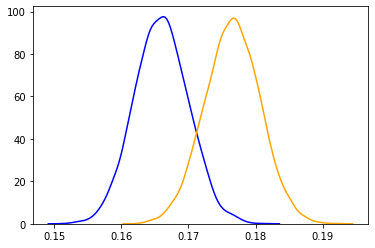

In [19]:
import seaborn as sns
sns.kdeplot(ctrl_simulation,color='blue')
sns.kdeplot(test_simulation,color='orange')

## Numerical Integration ##

[Text(0, 0.5, 'Test'), Text(0.5, 0, 'Control')]

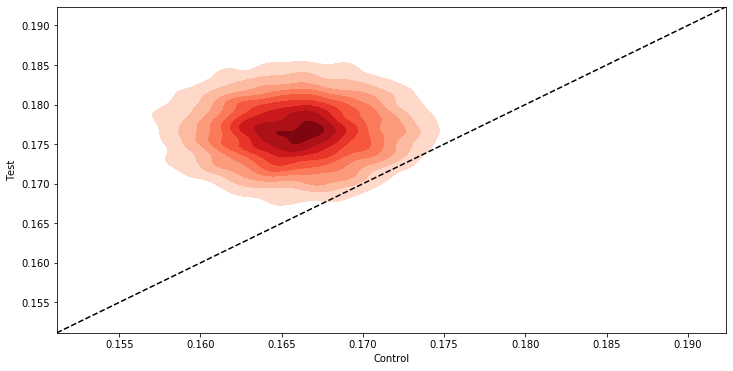

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax_min, ax_max = min(np.minimum(ctrl_simulation, test_simulation)), max(np.maximum(ctrl_simulation, test_simulation))
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)
facet = sns.kdeplot(ctrl_simulation, test_simulation, cmap="Reds", shade=True, shade_lowest=False)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color="black")
ax.set(xlabel='Control', ylabel='Test')

In [11]:
def num_integration(ctrl, test, a_C, a_T, b_C, b_T):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-b63fe53c7366>, line 2)

## Closed-form Solution ## 

Use the identity $log(B(a,b))=log(Γ(a))+log(Γ(b))−log(Γ(a+b))$ as python does not have log beta.

In [6]:
import math
def lbeta(a, b):
    total = math.lgamma(a) + math.lgamma(b) - math.lgamma(a+b)
    return total
    
def calc_ab(alpha_a, beta_a, alpha_b, beta_b):
    total = 0.0
    
    for i in range(alpha_b):
        num = lbeta(alpha_a + i, beta_a + beta_b)
        den = math.log(beta_b + i) + lbeta(1 + i, beta_b) + lbeta(alpha_a, beta_a)
        total += math.exp(num-den)
    return 1 - total # Returns P(X > Y)

print("P(A>B):",calc_ab(a_C,b_C,a_T,b_T)) # Probability of A being the best
print("P(B>A):",1 - calc_ab(a_C,b_C,a_T,b_T)) # Probability of B being the best

P(A>B): 0.033445756683454286
P(B>A): 0.9665542433165457


In [22]:
def loss(a, b, c, d):
    total = 0.0
    total = (lbeta(a+1,b)/lbeta(a,b) * calc_ab(a+1,b,c,d))
    - (lbeta(c+1,d)/lbeta(c,d) * calc_ab(a,b,c+1,d))
    return total
print(loss(a_C,b_C,a_T,b_T))
print(loss(a_T,b_T,a_C,b_C))

0.03475769360421172
0.9681953903555034


In [23]:
# Another implementation (more optimized?)
from math import lgamma
from numba import jit

# Formulas used to calculate P(A>B). No Monte Carlo simulation is required as A/B testing involves conjugate pairs, 
# allowing us to compute the exact solution.
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [24]:
from scipy.stats import beta
import numpy as np

#here we create the Beta functions for the two sets (add 1 from our uninformed priors)
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by 6.38% with 96.7% probability.


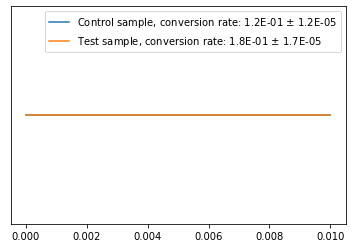

In [22]:
import matplotlib.pyplot as plt

def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0, lsup=0.01):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()

plot([beta_C, beta_T], names=["Control", "Test"])

## Closed-form Approximation ##

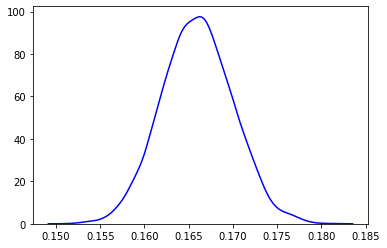

In [25]:
from scipy.stats import norm
# We can approximate a beta distribution using a normal distribution for decently large values of alpha and beta
u1 = a_C/(a_C + b_C)
var1 = (a_C * b_C)/(pow((a_C + b_C),2) * (a_C + b_C + 1))
sns.kdeplot(ctrl_simulation,color='blue')

In [26]:
import scipy
def h_approximation(a_C,b_C,a_T,b_T): # Normal approximation for beta distribution
    u_C = a_C/(a_C + b_C) 
    u_T = a_T/(a_T + b_T)
    var_C = (a_C * b_C)/(pow((a_C + b_C),2) * (a_C + b_C + 1))
    var_T = (a_T * b_T)/(pow((a_T + b_T),2) * (a_T + b_T + 1))
    return scipy.stats.norm.cdf(0,u_T - u_C,math.sqrt(var_C + var_T))

print("P(A>B):",h_approximation(a_C,b_C,a_T,b_T)) # Probability of A being the best
print("P(B>A):",1 - h_approximation(a_C,b_C,a_T,b_T)) # Probability of B being the best

P(A>B): 0.03345089364774475
P(B>A): 0.9665491063522552


Posterior P(A>B): 0.03345
Posterior P(B>A): 0.96655
Estimated Lift: 0.01059
95% Confidence Interval: [-0.00074, 0.02191]
Results are inconclusive. Consider collecting more data.


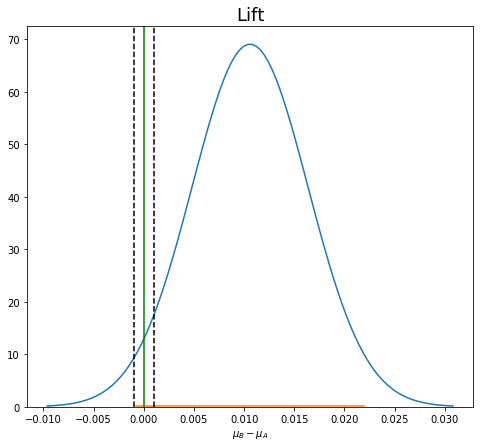

In [27]:
# Confidence Intervals (these are easy because we are using normal distributions)
def h_approximation_conf(a_C,b_C,a_T,b_T):
    u_C = a_C/(a_C + b_C) 
    u_T = a_T/(a_T + b_T)
    var_C = (a_C * b_C)/(pow((a_C + b_C),2) * (a_C + b_C + 1))
    var_T = (a_T * b_T)/(pow((a_T + b_T),2) * (a_T + b_T + 1))
    
    mu_diff = u_T - u_C
    sd_diff = math.sqrt(var_C + var_T)
    
    rope = 0.001
    posterior = scipy.stats.norm.cdf(0, mu_diff, sd_diff) # (-inf, 0] Gives evidence that the control is better than test
    low_conf = scipy.stats.norm.ppf(0.025, mu_diff, sd_diff)
    high_conf = scipy.stats.norm.ppf(0.975, mu_diff, sd_diff)
    
    print("Posterior P(A>B): {:.5f}".format(posterior))
    print("Posterior P(B>A): {:.5f}".format(1 - posterior))
    print("Estimated Lift: {:.5f}".format(mu_diff))
    print("95% Confidence Interval: [{:.5f}, {:.5f}]".format(low_conf, high_conf))

    x = np.linspace(-3.5 * sd_diff + mu_diff, 3.5 * sd_diff + mu_diff, 100)
    fig, ax = plt.subplots(figsize=(8, 7))
    plt.plot(x, scipy.stats.norm.pdf(x, mu_diff, sd_diff))
    plt.plot(np.linspace(low_conf,high_conf),np.full(50,0.1)) # Plot 95% HPD
    plt.axvline(0, color = 'green') # 
    plt.axvline(-rope, linestyle = "--", color = 'black') # 
    plt.axvline(rope, linestyle = "--", color = 'black') # 
    
    plt.xlabel("$\mu_B - \mu_A$")
    plt.gca().set_ylim(bottom=0)
    plt.title("Lift", fontsize=18)
    
    if (high_conf < -rope):
        print("Variant A is the winner.")
    elif (low_conf > rope):
        print("Variant B is the winner.")
    elif (low_conf > -rope) & (high_conf < rope):
        print("Variant A and B are equivalent.")
    else: 
        print("Results are inconclusive. Consider collecting more data.")

h_approximation_conf(a_C,b_C,a_T,b_T)
# Under ROPE (Region of Practical Equivalence)

3 Different Scenarios:
* If the 95% HPD lies both inside and outside of the ROPE, the results are inconclusive.
* If the 95% HPD lies completely to the right of the ROPE, variant B is the winner. Similarly, if the 95% HPD lies completely to the left of the ROPE, variant A is the winner.
* If the 95% HPD lies completely inside of the ROPE, the null value is accepted i.e variant A and B are equivalent

In [26]:
# Expected Loss


## Comparing with Frequentist ##

In [27]:
# Frequentist way of calculating conversion rate 
cr_control, cr_test = 30/16500, 50/17000
print(f"Conversion rate for control: {cr_control:.5f}")
print(f"Conversion rate for test: {cr_test:.5f}")
# Note that it's similar with the peak (mode) of the beta distributions above

Conversion rate for control: 0.00182
Conversion rate for test: 0.00294


mpf('0.48112566853812544')

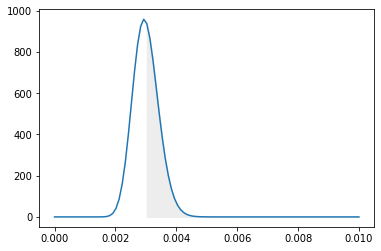

In [76]:
x=np.linspace(0,0.01,100)
y=beta_T.pdf(x) #this for calculate the value for the PDF at the specified x-points
y_mode=calc_beta_mode(beta_T.args[0], beta_T.args[1])
y_var=beta_T.var() # the variance of the Beta distribution
plt.plot(x,y)
plt.fill_between(x,y,where = x > 0.003, color="#ededed")

from mpmath import betainc
betainc(a_T, b_T, 0.003,1, regularized=True)
# Probability of the conversion rate being greater than 0.003

In [82]:
val_C

array([0.00169606, 0.00199785, 0.00215041, ..., 0.00154198, 0.00205249,
       0.00214055])

KeyboardInterrupt: 

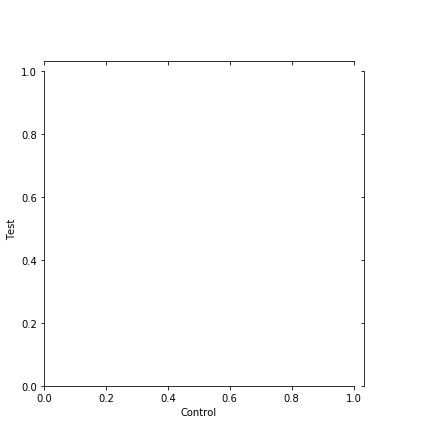

In [78]:
# Approximation using Monte Carlo 
import seaborn as sns
import pandas as pd
import numpy as np
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

#Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

val_C=np.random.beta(a_C, b_C, 1000000)
val_T=np.random.beta(a_T, b_T, 1000000)
vals=np.vstack([val_C, val_T]).T

limit=0.004

df=pd.DataFrame(vals, columns=['Control', 'Test'])
df=df[df['Control']<limit]
df=df[df['Test']<limit]
g=sns.jointplot(x=df.Control, y=df.Test, kind='kde', n_levels=15)
g.ax_joint.plot([0.0015, limit], [0.0015, limit])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_B, p_A]
Sampling 2 chains: 100%|██████████| 61000/61000 [00:26<00:00, 2332.00draws/s]
/Users/isaac/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/isaac/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce

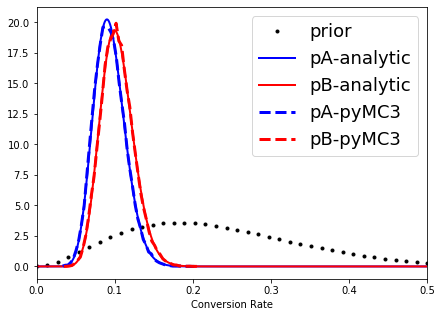

In [141]:
from scipy.stats import beta
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

pA_true = 0.05
pB_true = 0.07

N_A = 200
N_B = 200

obs_A = np.random.binomial(1, pA_true, size=N_A)
obs_B = np.random.binomial(1, pB_true, size=N_B)

alpha_prior = 3
beta_prior = 10

np.random.seed(123)
with pm.Model() as ab_model:
    #priors
    p_A = pm.distributions.continuous.Beta('p_A',alpha=alpha_prior,beta=beta_prior)
    p_B = pm.distributions.continuous.Beta('p_B',alpha=alpha_prior,beta=beta_prior)
    #likelihoods
    likelihood_A = pm.Bernoulli('likelihood_A', p_A, observed=obs_A)
    likelihood_B = pm.Bernoulli('likelihood_B', p_B, observed=obs_B)

    trace = pm.sample(30000)

cA = np.sum(obs_A)
nA = len(obs_A)

cB = np.sum(obs_B)
nB = len(obs_B)

nvals = 1000

prior = [beta.pdf(x, alpha_prior, beta_prior) for x in np.linspace(0,1,75)]
pA_analytic = [beta.pdf(x, alpha_prior + cA, beta_prior + nA-cA) for x in np.linspace(0,1,nvals)]
pB_analytic = [beta.pdf(x, alpha_prior + cB, beta_prior + nB-cB) for x in np.linspace(0,1,nvals)]

pA_numerical, edges_A = np.histogram(trace['p_A'][1000:],normed=True,bins=50)
pB_numerical, edges_B = np.histogram(trace['p_B'][1000:],normed=True,bins=50)
x_A = 0.5 * (edges_A[0:-1] + edges_A[1:])
x_B = 0.5 * (edges_B[0:-1] + edges_B[1:])

fig = plt.figure(figsize=(7, 5))

x = np.linspace(0,1,nvals)
plt.plot(np.linspace(0,1,75), prior, 'k.', label='prior')
plt.plot(x, pA_analytic, 'b',lw=2, label='pA-analytic')
plt.plot(x, pB_analytic, 'r',lw=2, label='pB-analytic')
plt.plot(x_A, pA_numerical,'--b',lw=3, label='pA-pyMC3')
plt.plot(x_B, pB_numerical,'--r',lw=3, label='pB-pyMC3')
plt.xlim([0.0,0.5])
plt.xlabel('Conversion Rate')
plt.legend(loc=1,fontsize=18)

In [160]:
len(trace['p_A'])

60000

In [145]:
pA_numerical

array([2.95475945e-02, 9.84919815e-02, 1.08341180e-01, 3.15174341e-01,
       6.50047078e-01, 1.30994335e+00, 2.14712520e+00, 3.41767176e+00,
       4.91474988e+00, 7.43122001e+00, 9.91814254e+00, 1.23558191e+01,
       1.47147020e+01, 1.65860497e+01, 1.82062428e+01, 1.96048289e+01,
       1.96442257e+01, 1.95752813e+01, 1.91813134e+01, 1.84967941e+01,
       1.71228310e+01, 1.50988208e+01, 1.33949095e+01, 1.17697918e+01,
       9.61281740e+00, 7.98769970e+00, 6.58418896e+00, 5.05263865e+00,
       3.89043327e+00, 3.14189421e+00, 2.20622039e+00, 1.78270487e+00,
       1.18190378e+00, 1.03416581e+00, 6.05725686e-01, 4.28440120e-01,
       3.00400544e-01, 2.21606958e-01, 1.37888774e-01, 7.87935852e-02,
       6.40197880e-02, 2.95475945e-02, 2.95475945e-02, 3.44721935e-02,
       2.46229954e-02, 9.84919815e-03, 4.92459908e-03, 9.84919815e-03,
       0.00000000e+00, 4.92459908e-03])

In [168]:
len(edges_A)

51

In [167]:
len(pA_numerical)

50

In [165]:
len(edges_A[0:-1])

50

In [166]:
len(edges_A[1:])

50

In [175]:
samp = [1.0,2.0,3.0,4.0,5.0]

In [176]:
0.5 * (samp[0:-1] + samp[1:])

TypeError: can't multiply sequence by non-int of type 'float'

In [150]:
samp[1:]

[2, 3, 4, 5]

In [162]:
len(x_A)

50

In [182]:
edges_A

array([0.03159064, 0.03503237, 0.0384741 , 0.04191583, 0.04535757,
       0.0487993 , 0.05224103, 0.05568276, 0.0591245 , 0.06256623,
       0.06600796, 0.06944969, 0.07289143, 0.07633316, 0.07977489,
       0.08321662, 0.08665836, 0.09010009, 0.09354182, 0.09698355,
       0.10042529, 0.10386702, 0.10730875, 0.11075048, 0.11419222,
       0.11763395, 0.12107568, 0.12451741, 0.12795915, 0.13140088,
       0.13484261, 0.13828434, 0.14172608, 0.14516781, 0.14860954,
       0.15205127, 0.15549301, 0.15893474, 0.16237647, 0.1658182 ,
       0.16925994, 0.17270167, 0.1761434 , 0.17958513, 0.18302687,
       0.1864686 , 0.18991033, 0.19335206, 0.1967938 , 0.20023553,
       0.20367726])

In [179]:
edges_A[0:-1]

array([0.03159064, 0.03503237, 0.0384741 , 0.04191583, 0.04535757,
       0.0487993 , 0.05224103, 0.05568276, 0.0591245 , 0.06256623,
       0.06600796, 0.06944969, 0.07289143, 0.07633316, 0.07977489,
       0.08321662, 0.08665836, 0.09010009, 0.09354182, 0.09698355,
       0.10042529, 0.10386702, 0.10730875, 0.11075048, 0.11419222,
       0.11763395, 0.12107568, 0.12451741, 0.12795915, 0.13140088,
       0.13484261, 0.13828434, 0.14172608, 0.14516781, 0.14860954,
       0.15205127, 0.15549301, 0.15893474, 0.16237647, 0.1658182 ,
       0.16925994, 0.17270167, 0.1761434 , 0.17958513, 0.18302687,
       0.1864686 , 0.18991033, 0.19335206, 0.1967938 , 0.20023553])

In [180]:
edges_A[1:]

array([0.03503237, 0.0384741 , 0.04191583, 0.04535757, 0.0487993 ,
       0.05224103, 0.05568276, 0.0591245 , 0.06256623, 0.06600796,
       0.06944969, 0.07289143, 0.07633316, 0.07977489, 0.08321662,
       0.08665836, 0.09010009, 0.09354182, 0.09698355, 0.10042529,
       0.10386702, 0.10730875, 0.11075048, 0.11419222, 0.11763395,
       0.12107568, 0.12451741, 0.12795915, 0.13140088, 0.13484261,
       0.13828434, 0.14172608, 0.14516781, 0.14860954, 0.15205127,
       0.15549301, 0.15893474, 0.16237647, 0.1658182 , 0.16925994,
       0.17270167, 0.1761434 , 0.17958513, 0.18302687, 0.1864686 ,
       0.18991033, 0.19335206, 0.1967938 , 0.20023553, 0.20367726])

In [183]:
0.5 * (edges_A[0:-1] + edges_A[1:])

array([0.0333115 , 0.03675324, 0.04019497, 0.0436367 , 0.04707843,
       0.05052017, 0.0539619 , 0.05740363, 0.06084536, 0.0642871 ,
       0.06772883, 0.07117056, 0.07461229, 0.07805403, 0.08149576,
       0.08493749, 0.08837922, 0.09182096, 0.09526269, 0.09870442,
       0.10214615, 0.10558789, 0.10902962, 0.11247135, 0.11591308,
       0.11935482, 0.12279655, 0.12623828, 0.12968001, 0.13312175,
       0.13656348, 0.14000521, 0.14344694, 0.14688868, 0.15033041,
       0.15377214, 0.15721387, 0.1606556 , 0.16409734, 0.16753907,
       0.1709808 , 0.17442253, 0.17786427, 0.181306  , 0.18474773,
       0.18818946, 0.1916312 , 0.19507293, 0.19851466, 0.20195639])

In [2]:
chr(ord('A') + 1)

'B'